We use ST human melanoma data as an example to show how to use DIST python package to perform self-supervised learning Spatial Transcriptomics enhancement.
In the following, we analysis mel1_rep1, a sample of human melanoma data. The count matrix of mel1_rep1 can be found in folder *data* or be downloaded from [spatialresearch.org](https://www.spatialresearch.org/resources-published-datasets/doi-10-1158-0008-5472-can-18-0747/)

In [4]:
import anndata as ad
import scanpy as sc
from DIST import *

## Data preparation

Load count matrix and spot coordinates matrix of mel1_rep1 to create anndata.AnnData object.  
Self-learning means training set and test set are from the same saptial transcriptomic data, so we only load a sample.

In [5]:
file_path="data/mel1_rep1/"
counts=pd.read_csv(file_path+"counts.csv",index_col=0)
coords=pd.read_csv(file_path+"coords.csv",index_col=0)
adata=ad.AnnData(X=counts.values, obs=coords, var=pd.DataFrame(index=counts.columns.values))
adata

AnnData object with n_obs × n_vars = 279 × 15666
    obs: 'array_row', 'array_col'

Define integral_coords. It describes row and column coordinates of some original spots that are expected to preserve. Usually, intergral_coords contains the initial spots of test data without quality control. We add manually some spots coordinates which we want to preserve for tissue structural integrity.

In [6]:
integral_coords = adata.obs[['array_row','array_col']] # This sentence is enough for most saptial transcriptomic data.

integral_coords.loc["5x10",:]=[5,10] # We add three spots since they are in tissue but missing. 
integral_coords.loc["10x14",:]=[10,14]
integral_coords.loc["15x22",:]=[15,22]

Quality Control.

In [7]:
sc.pp.calculate_qc_metrics(adata, inplace=True)
sc.pp.filter_cells(adata, min_genes=20)
sc.pp.filter_genes(adata, min_cells=10)

Prepare for training set.  
In the training process, we choose genes that expressed on over ten percent of total spots. The percentage can be adjusted.


In [8]:
train_adata=adata[:,adata.var["n_cells_by_counts"]>len(adata.obs.index)*0.1]
train_counts=np.array(train_adata.X)
train_coords=train_adata.obs[['array_row','array_col']]

Prepare for test set.

In [9]:
test_adata=adata
test_counts=np.array(test_adata.X)
test_coords=test_adata.obs[['array_row','array_col']]

## DIST imputation

Create training and test dataset from expression and cooridate matrix.  
Get information about imputed coordinates for transforming outputs of DIST network into expression and coordinates matrices.

In [10]:
train_set=getSTtrainset(train_counts, train_coords)
test_set=getSTtestset(test_counts, test_coords)
position_info=get_ST_position_info(integral_coords)

Creating training set costs:  6.78 s
Creating testing set costs:  7.08 s


Run DIST.

In [22]:
imputed_img = DIST(train_set, test_set, epoch=200, batch_size=512, gpu='1')
imputed_counts, imputed_coords = img2expr(imputed_img, adata.var_names, integral_coords, position_info)

Training: 100%[##################################################->]79.24s

Testing: 100%[##################################################->]17.35s



Here, we have gotten imputed expression matrix and its spots coordinates matrix. You can create anndata.AnnData object for imputed expression, if necessary.

In [23]:
imputed_adata=ad.AnnData(X=imputed_counts,obs=imputed_coords)
imputed_adata

AnnData object with n_obs × n_vars = 1060 × 10266
    obs: 'array_row', 'array_col'

--------------------------------------------------
Next, we visualize some genes to show the effect of DIST.
## Visualization

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_genes(adata, show_genes, n=4, size=(20,5),point_size=30, titles=None,cmap=None):
    if titles==None:
        titles=show_genes
    genes_index=[list(adata.var_names).index(gene) for gene in show_genes]
    m=len(show_genes)//n+1
    plt.figure(figsize=size)
    flag=0
    for j in range(m):
        show_genes0=show_genes[j*n:min(len(show_genes),(j+1)*n)]
        
        for i in range(n):
            if not i<len(show_genes0):
                break
            plt.subplot(m,n,flag+1)
        
            plt.scatter(adata.obs['array_row'],adata.obs['array_col'],c=np.array(adata.X)[:,genes_index[flag]],
                        marker='s',s=point_size, vmin=0,cmap=cmap)
            plt.title(titles[flag])
            plt.xticks([])
            plt.yticks([])
            plt.axis('off')
            flag+=1

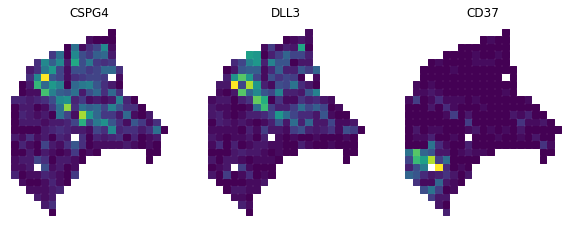

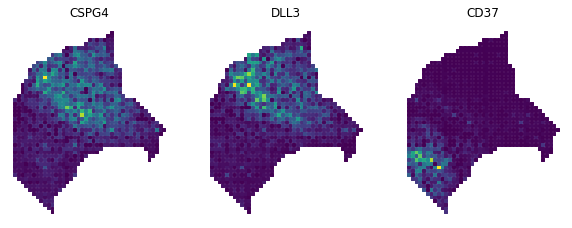

In [41]:
show_genes=['CSPG4','DLL3','CD37']
plot_genes(adata, show_genes, n=3, size=(10,8),point_size=42)
plot_genes(imputed_adata, show_genes, n=3, size=(10,8),point_size=8)